In [1]:
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit import pulse 
from qiskit import IBMQ

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

IBMQ.save_account("26595118309e0ea848015d3f7458b040ec723a9c11afd2d777038533a5a2b8079312af1e3713e370053f85bf7dd5d77f72993b0f04c2cd561e4c31f5a40c910c")
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_rome')

configrc.store_credentials:WARNING:2021-03-25 21:40:52,258: Credentials already present. Set overwrite=True to overwrite.
C:\Users\Just\Downloads\WPy32-3800\python-3.8.0\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [3]:
backend_defaults = backend.defaults()

In [20]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
#qubit = 0
frequencies_GHzs = []
for qubit in range(5):
# The sweep will be centered around the estimated qubit frequency.
    center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
    print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
    scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
    frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
    frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
    frequency_min = center_frequency_Hz - frequency_span_Hz / 2
    frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
    frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)
    
    frequencies_GHzs.append(frequencies_GHz)

    print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.968706784683522 GHz.
The sweep will go from 4.948706784683522 GHz to 4.988706784683522 GHz in steps of 1.0 MHz.
Qubit 1 has an estimated frequency of 4.770100425613072 GHz.
The sweep will go from 4.7501004256130726 GHz to 4.790100425613073 GHz in steps of 1.0 MHz.
Qubit 2 has an estimated frequency of 5.015169715135454 GHz.
The sweep will go from 4.995169715135455 GHz to 5.035169715135454 GHz in steps of 1.0 MHz.
Qubit 3 has an estimated frequency of 5.259254705121948 GHz.
The sweep will go from 5.239254705121948 GHz to 5.279254705121948 GHz in steps of 1.0 MHz.
Qubit 4 has an estimated frequency of 4.997536166924889 GHz.
The sweep will go from 4.97753616692489 GHz to 5.01753616692489 GHz in steps of 1.0 MHz.


In [21]:
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [22]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib


# Drive pulse parameters (us = microseconds)
#drive_sigma_us = 0.004444  
# This determines the actual width of the gaussian
#0.0075
drive_sigma_us = 0.009
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.05
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [23]:
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [24]:
drive_sigma

48

In [25]:
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [26]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [27]:
drive = []
meas = []
acq = []
for qubit in range(5):
    drive_chan = pulse.DriveChannel(qubit) 
    drive.append(drive_chan)
    meas_chan = pulse.MeasureChannel(qubit)
    meas.append(meas_chan)
    acq_chan = pulse.AcquireChannel(qubit)
    acq.append(acq_chan)

In [28]:
schedule = pulse.Schedule(name='Frequency sweep')
schedule_frequencies = []
for i, j in enumerate(drive):
    schedule += Play(drive_pulse, j)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
    

# Create the frequency settings for the sweep (MUST BE IN HZ)
    frequencies_Hz = frequencies_GHzs[i]*GHz
    schedule_frequencies += [{j: freq} for freq in frequencies_Hz]
    
schedule += measure << schedule.duration

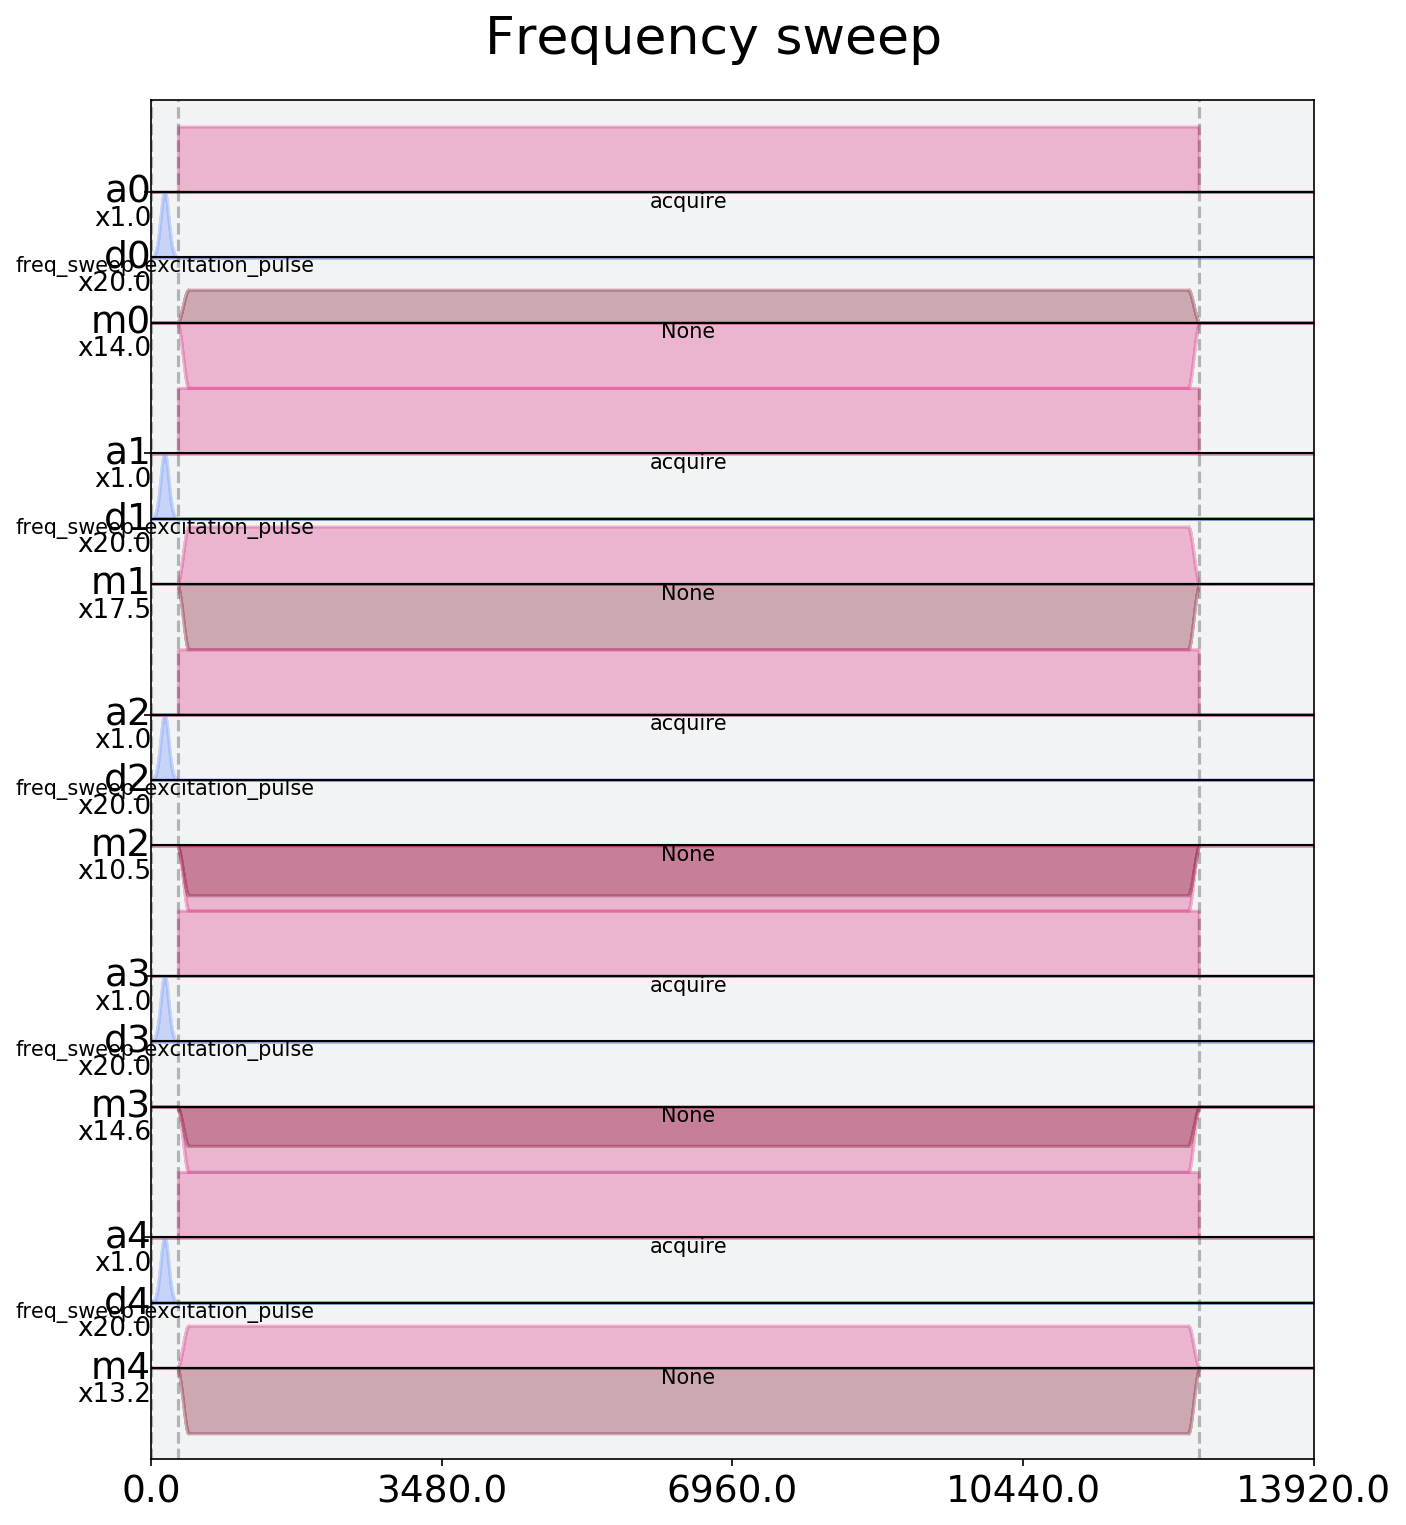

In [29]:
schedule.draw(label=True)

In [30]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

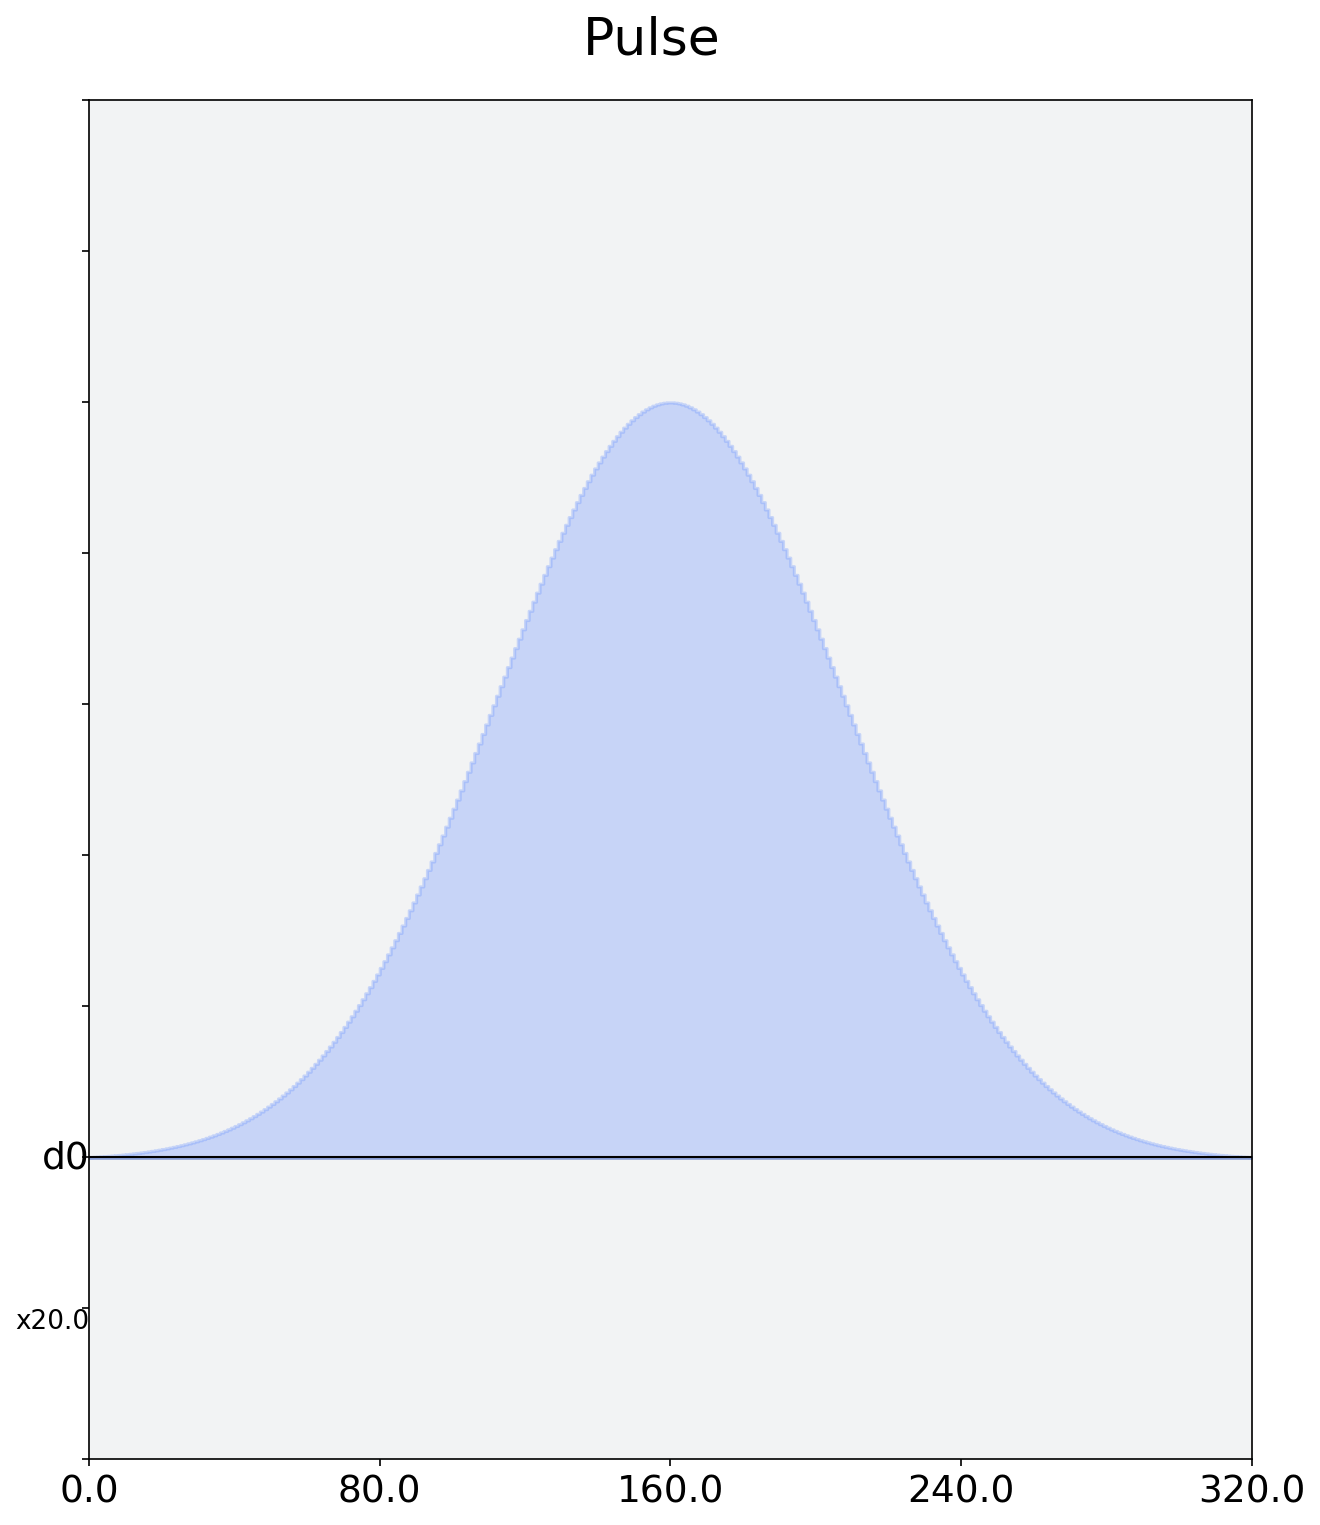

In [31]:
job = backend.run(frequency_sweep_program)
from qiskit import pulse
with pulse.build(name='Pulse') as arb:
    pulse.play(drive_pulse,
               pulse.DriveChannel(0))
arb.draw()


In [32]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [33]:
frequency_sweep_results = job.result(timeout=120)

In [34]:
scale_factor = 1e-7

41


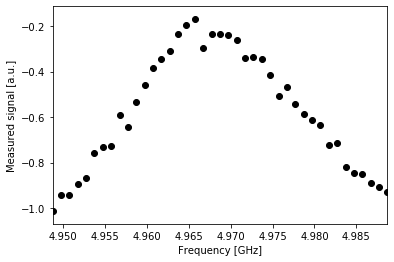

41


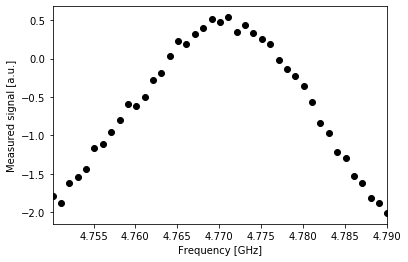

41


ValueError: x and y must be the same size

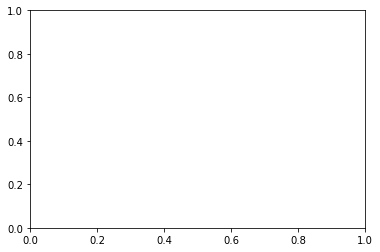

In [35]:
import matplotlib.pyplot as plt
qubit = 0
sweep_values_total = []
for j in range(5):
    sweep_values = []
    #for i in range(len(frequency_sweep_results.results)):
    for i in range(41*j,41*(j+1)):
    # Get the results from the ith experiment
        res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
        sweep_values.append(res[j])
    #frequency_q= list(frequency_for_qubits[j])*7
    print(len(sweep_values))
    sweep_values_total.append(sweep_values)
    plt.scatter(frequencies_GHzs[j], np.real(sweep_values), color='black') # plot real part of sweep values
    plt.xlim([min(frequencies_GHzs[j]), max(frequencies_GHzs[j])])
    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Measured signal [a.u.]")
    plt.show()

In [ ]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [ ]:
Q_freq=[]
for i in range(5):
    fit_params, y_fit = fit_function(frequencies_GHzs[i],
                                 np.real(np.real(sweep_values_total[i])), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [0.02, frequencies_GHzs[i][20], 0.002, -2.17] # initial parameters for curve_fit
                                )
    plt.scatter(frequencies_GHzs[i], np.real(sweep_values_total[i]), color='black')
    plt.plot(frequencies_GHzs[i], y_fit, color='red')
    plt.xlim([min(frequencies_GHzs[i]), max(frequencies_GHzs[i])])

    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Measured Signal [a.u.]")
    plt.show()
    Q_freq.append(fit_params[1])

In [ ]:
Q_freq

In [ ]:
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.20
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [ ]:
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive[0])
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

In [ ]:
rabi_schedules[-1].draw(label=True)

In [ ]:
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: Q_freq[0]*GHz}]
                                                * num_rabi_points)

In [ ]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

In [ ]:
rabi_results = job.result(timeout=120)

In [ ]:
def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [ ]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

In [ ]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/4*3, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
#plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
#plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()
print(fit_params)

In [ ]:
fit_params[2]

In [ ]:
pi_half_amp = abs(drive_period / 4)
pi_amp= abs(drive_period / 2)
print(f"Square root x (amp.)= {pi_half_amp}")
print(f"Square root x (amp.)= {pi_amp}")

# Ramsey

In [34]:
time_max_us = 1.5
time_step_us = 0.025
times_us = np.arange(0.025, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2
# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
x90_pulse = pulse_lib.gaussian(duration=drive_samples,
                               amp=drive_amp, 
                               sigma=drive_sigma,
                               name='x90_pulse')

In [35]:
ramsey_schedules = []

for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"Ramsey delay = {delay * dt / us} us")
    this_schedule |= Play(x90_pulse, drive[0])
    this_schedule |= Play(x90_pulse, drive[0]) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)

    ramsey_schedules.append(this_schedule)

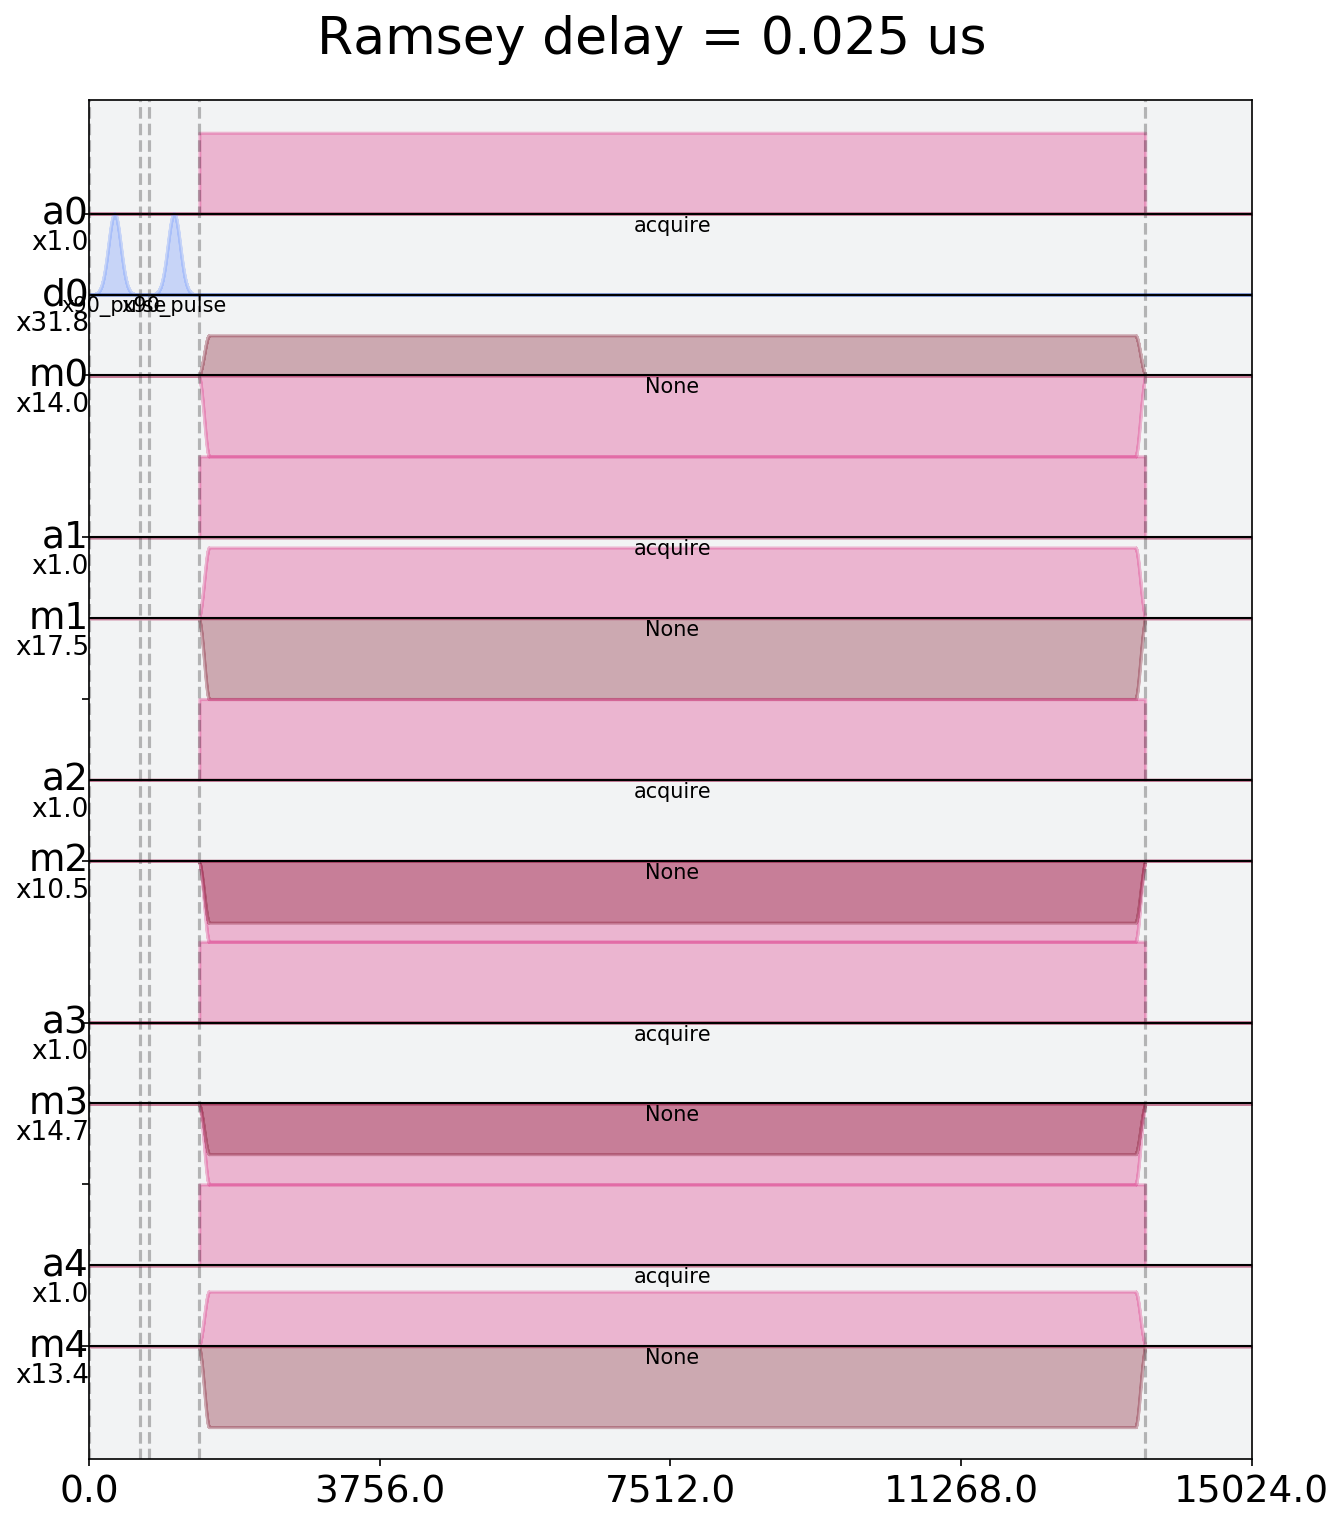

In [36]:
ramsey_schedules[0].draw(label=True)

In [37]:
num_shots = 256

detuning_MHz = -1
ramsey_frequency = round(Q_freq[0]*GHz + detuning_MHz * MHz, 6) # need ramsey freq in Hz
ramsey_program = assemble(ramsey_schedules,
                             backend=backend,
                             meas_level=1,
                             meas_return='avg',
                             shots=num_shots,
                             schedule_los=[{drive_chan: ramsey_frequency}]*len(ramsey_schedules)
                            )

In [38]:
job = backend.run(ramsey_program)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [39]:
ramsey_results = job.result(timeout=120)

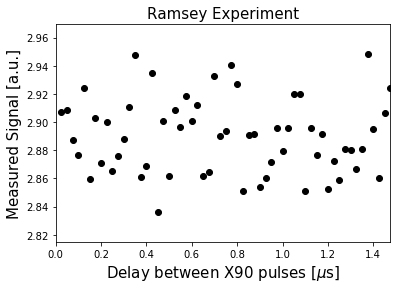

In [40]:
ramsey_values = []
for i in range(len(times_us)):
    ramsey_values.append(ramsey_results.get_memory(i)[0]*scale_factor)
    
plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(times_us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

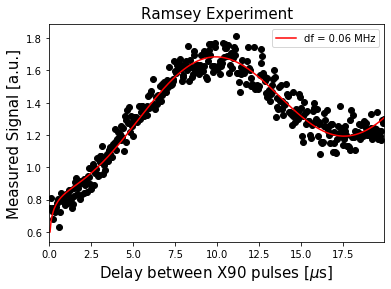

In [151]:
fit_params, y_fit = fit_function(times_us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A* np.cos(2*np.pi*del_f_MHz*x - 0.56) + B*x**(C)
                                         ),
                                 [0.15588132, 0.0554278,  -0.04492174, 2.21367894]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [152]:
fit_params

array([-0.28611517,  0.0613182 ,  0.09538593,  1.12446777])

In [114]:
precise_qubit_freq = Q_freq[0]*GHz + (del_f_MHz - detuning_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(Q_freq[0]*GHz / GHz, 6)} GHz")

Our updated qubit frequency is now 4.968918 GHz. It used to be 4.968918 GHz


In [ ]:
ramsey_results.get_memory(0)

In [ ]:
pi_half_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_half_amp, 
                              sigma=drive_sigma,
                              name='Square root x')

In [ ]:
from qiskit import pulse
with pulse.build(name='Square root x') as xrx:
    pulse.play(pi_half_pulse,
               pulse.DriveChannel(0))

In [ ]:
xrx.draw()

In [ ]:
def X_circuit1(n=20,qubit=0):
    Xcircuit = []
    
    for i in range(n):
        
        xcircuit_z_q0 = QuantumCircuit(5,1)
        xcircuit_x_q0 = QuantumCircuit(5,1)
        xcircuit_y_q0 = QuantumCircuit(5,1)
        for j in range(i):
            xcircuit_z_q0.sx(qubit)
            xcircuit_z_q0.sx(qubit)
            
            xcircuit_z_q0.barrier()
            xcircuit_z_q0.sx(qubit)
            xcircuit_z_q0.sx(qubit)
            
            xcircuit_z_q0.barrier()
        
            xcircuit_x_q0.sx(qubit)
            xcircuit_x_q0.sx(qubit)
            
            xcircuit_x_q0.barrier()
            xcircuit_x_q0.sx(qubit)
            xcircuit_x_q0.sx(qubit)
            
            xcircuit_x_q0.barrier()
        
            xcircuit_y_q0.sx(qubit)
            xcircuit_y_q0.sx(qubit)
            
            xcircuit_y_q0.barrier()
            xcircuit_y_q0.sx(qubit)
            xcircuit_y_q0.sx(qubit)
            
            xcircuit_y_q0.barrier()
        
        xcircuit_x_q0.h(qubit)
        
        xcircuit_y_q0.sdg(qubit) 
        xcircuit_y_q0.h(qubit)
        
        xcircuit_z_q0.measure(qubit,0)
        xcircuit_x_q0.measure(qubit,0)
        xcircuit_y_q0.measure(qubit,0)
        
        xcircuit_z_q0.add_calibration('sx', [0], xrx)
        xcircuit_x_q0.add_calibration('sx', [0], xrx)
        xcircuit_y_q0.add_calibration('sx', [0], xrx)
        
        xcircuit_z_q0 = transpile(xcircuit_z_q0, backend)
        xcircuit_x_q0 = transpile(xcircuit_x_q0, backend)
        xcircuit_y_q0 = transpile(xcircuit_y_q0, backend)
        
        Xcircuit.append(xcircuit_z_q0)
        Xcircuit.append(xcircuit_x_q0)
        Xcircuit.append(xcircuit_y_q0)
        
    return Xcircuit

In [ ]:
q=0

qr = QuantumRegister(5)

qubit_list = [q]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

circuit_x = X_circuit1(20,0)

In [ ]:
reps=2

all_jobs = []
all_jobs_mit = []

for ii in range(reps):

    # Run QPT on backend
    shots = 8192
    il = [0,1,2,3,4] 
    
    #job_backend = execute(stabilizer_circuits, Aer.get_backend('qasm_simulator'), shots=shots, initial_layout=il,basis_gates=basis_gates,noise_model=noise_model)
    job_backend = execute(circuit_x, backend, shots=shots, initial_layout=il)
    
    #job_mit_backend = execute(meas_cal_circuits, Aer.get_backend('qasm_simulator'), shots=shots, initial_layout=il,basis_gates=basis_gates,noise_model=noise_model)
    job_mit_backend = execute(meas_calibs, backend, shots=shots, initial_layout=il)
    
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)

In [ ]:
for job in all_jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

In [ ]:
cal_results = all_jobs_mit[1].result()
results = all_jobs[1].result()

In [ ]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

In [ ]:
meas_fitter.plot_calibration()

In [ ]:
from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np

Result_nomit = results.get_counts(0) 
mitigated_counts = meas_fitter.filter.apply(results).get_counts(0)
plot_histogram([Result_nomit, mitigated_counts], legend=['raw', 'mitigated'])

In [ ]:
(0.719/0.990)**(1/80)